# Imports

In [1]:
import pennylane as qml

import numpy as np

from matplotlib import pyplot as plt

In [2]:
dev = qml.device("default.qubit", wires=2)

# VQE

## Exact diagonalization

In [8]:
# Pauli matrices
Id = np.eye(2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

In [9]:
parameters = np.loadtxt("data/HamiltonianParameters.txt")

In [11]:
R = 90
H_param = parameters[parameters[:,0]==R,1:].flatten()
H_param.shape

(9,)

In [6]:
C = H_param[0]
Jx = H_param[1]
Jz = H_param[2]
#Jx = H_param[3]
Jxx = H_param[4]
Jxz = H_param[5]
#Jz = H_param[6]
#Jzx = H_param[7]
Jzz = H_param[8]

print(f"Jx={Jx}, Jz={Jz}, Jxx={Jxx}, Jzz={Jzz}, Jxz={Jxz}, C={C}")

Jx=-0.2288, Jz=-1.0466, Jxx=0.2613, Jzz=0.2356, Jxz=0.2288, C=-3.8505


In [14]:
def Hamiltonian():
    H = Jx * (np.kron(X,Id) + np.kron(Id,X))
    H = H + Jz * (np.kron(Z,Id) + np.kron(Id,Z))
    H = H + Jxx * np.kron(X,X)
    H = H + Jzz * np.kron(Z,Z)
    H = H + Jxz * (np.kron(X,Z) + np.kron(Z,X))
    H = H + C * np.kron(Id,Id)

    return H/2

In [15]:
def exactEnergy():
    H = Hamiltonian()

    E, V = np.linalg.eigh(H)
    return np.min(E)

print(f"Exact ground state energy is E = {exactEnergy()}")

Exact ground state energy is E = -2.8626207640766816


## Ansatz and VQE Circuit

In [40]:
@qml.qnode(dev)
def ansatz(params, basis):
    theta = params
    print(basis)
    print(theta)

    # inital rotations
    qml.RX(theta[0], wires=0)
    qml.RZ(theta[1], wires=0)
    qml.RX(theta[2], wires=1)
    qml.RZ(theta[3], wires=1)

    # CNOT to entangle
    qml.CZ(wires=[0,1])

    # second round of rotations
    qml.RX(theta[4], wires=0)
    qml.RZ(theta[5], wires=0)
    qml.RX(theta[6], wires=1)
    qml.RZ(theta[7], wires=1)

    qml.U3(basis[0]*np.pi/2, 0, basis[0]*np.pi, wires=0)  # apply hadamard gate to qubit 0 iff basis[0]=1
    qml.U3(basis[1]*np.pi/2, 0, basis[1]*np.pi, wires=1)  # apply hadamard gate to qubit 1 iff basis[1]=1

    return qml.probs(wires=[0,1])


In [24]:
theta = list(2*np.pi*np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]))
angles = theta
basis = [1, 1]

In [25]:
test_circuit = ansatz(angles, basis)
print(test_circuit)

[0.16568909 0.38769228 0.17296344 0.27365519]


(<Figure size 900x300 with 1 Axes>, <Axes: >)

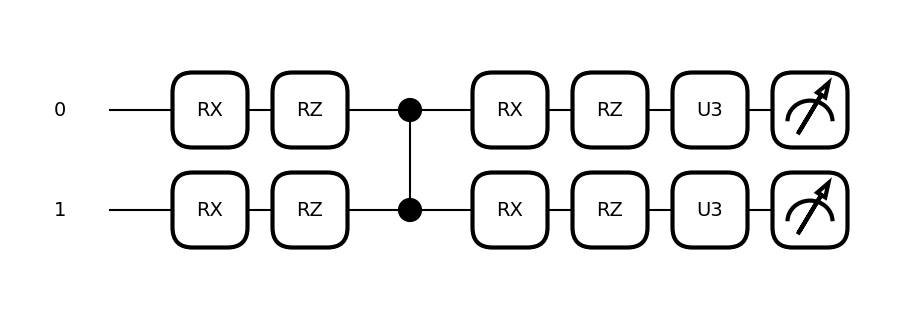

In [27]:
qml.drawer.use_style("black_white")
qml.draw_mpl(ansatz)(angles, basis)

In [28]:
def get_expectation(gate, probabilities):
    II = np.array([1,1,1,1])
    IZ = np.array([1,-1,1,-1])
    ZI = np.array([1,1,-1,-1])
    ZZ = np.array([1,-1,-1,1])

    probabilities = np.array(probabilities)

    if gate == 'II':
        return np.dot(II, probabilities)
    if gate == 'IZ' or gate == 'IX':
        return np.dot(IZ, probabilities)
    if gate == 'ZI' or gate == 'XI':
        return np.dot(ZI, probabilities)
    if gate == 'ZZ' or gate == 'XX' or gate == 'XZ' or gate == 'ZX':
        return np.dot(ZZ, probabilities)

    return 'Unidentified Gate'

In [29]:
def energy(probs_XX, probs_XZ, probs_ZX, probs_ZZ):
    """
    counts - dictionary of measured counts, e.g., {'00': 4096, '11': 4096}
    shots - total number of shots for each basis (for convenience. Can be computed from counts)
    """
    # Replace with code to convert counts to expectation values to get energy expectation.

    E_H = 0
    E_H += Jx*(get_expectation('XI', probs_XX) + get_expectation('IX', probs_XX))
    E_H += Jz*(get_expectation('ZI', probs_ZZ) + get_expectation('IZ', probs_ZZ))
    E_H += Jxx*get_expectation('XX', probs_XX)
    E_H += Jzz*get_expectation('ZZ', probs_ZZ)
    E_H += Jxz*(get_expectation('XZ', probs_XZ) + get_expectation('ZX', probs_ZX))
    E_H += C
    E_H *= 0.5

    return E_H

In [33]:
# compute the energy of the ansatz circuit for given parameters as a test
shots = 81920
theta = list(2*np.pi*np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]))

probsXX = ansatz(theta, [1,1], shots=shots)
probsXZ = ansatz(theta, [1,0], shots=shots)
probsZX = ansatz(theta, [0,1], shots=shots)
probsZZ = ansatz(theta, [0,0], shots=shots)
E_0 = energy(probsXX, probsXZ, probsZX, probsZZ)

print(f"My energy is E = {E_0}")

My energy is E = -1.080965588378906


In [48]:
# compute energy using batching
angles = 2*np.pi*np.array([[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]]*4).T
probs = ansatz(angles, np.array([[1,1],[1,0],[0,1],[0,1]]), shots=shots)
E_1 = energy(probs[0], probs[1], probs[2], probs[3])

print(f"My batched energy is E = {E_1}")

print(f"The correct energy (for these parameters) is E = -1.083 ± 0.012 (margin due to finite number of shots)")

AttributeError: 'list' object has no attribute 'T'